# Yankees - Event Propensity - Next Event Buyer
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [3]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [4]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ·····················


In [11]:
cursor = CNXN.cursor()

query =  f"""
    SELECT
        daysOut,
        dimCustomerMasterId,
        recent_openRate,
        recent_clickRate,
        eventDate,
        inMarket,
        distanceToVenue,
        tenure,
        did_purchase,
        events_purchased,
        frequency_opponent,
        frequency_eventDay,
        frequency_eventTime
    FROM DataScience.yankees.event_propensity_training
    """
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341266 entries, 0 to 341265
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              341266 non-null  object        
 1   dimCustomerMasterId  341266 non-null  int64         
 2   recent_openRate      341266 non-null  float64       
 3   recent_clickRate     341266 non-null  float64       
 4   eventDate            341266 non-null  datetime64[ns]
 5   inMarket             299741 non-null  object        
 6   distanceToVenue      299741 non-null  float64       
 7   tenure               341266 non-null  int64         
 8   did_purchase         341266 non-null  int64         
 9   events_purchased     341266 non-null  int64         
 10  frequency_opponent   341266 non-null  float64       
 11  frequency_eventDay   341266 non-null  float64       
 12  frequency_eventTime  341266 non-null  float64       
dtypes: datetime64[

In [13]:
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="yankees_pandas_profile_events.html")

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### We should specify the features used in our model:

In [14]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (290076, 13)
Unseen Data For Predictions: (51190, 13)



In [15]:
df_train.head()

,daysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
141211,4 to 7 Days Out,23861648,0.0,0.0,2019-09-20,True,47.50,0,1,3,0.00,0.000000,0.000000
124283,4 to 7 Days Out,3067056,0.0,0.0,2019-09-18,None,NaN,461,0,123,0.00,0.000000,0.014085
216305,Over a Week,700267,0.0,0.0,2019-09-03,True,9.54,444,0,118,0.00,0.000000,0.000000
226455,Over a Week,1055646,0.0,0.0,2017-08-01,False,3263.22,92,0,36,0.00,0.166667,0.041667
269684,Over a Week,2009681,0.0,0.0,2019-06-11,True,30.32,415,1,103,0.25,0.066667,0.000000


### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [22]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["daysOut", "inMarket"],
    date_features=["eventDate"],
    ignore_features=["dimCustomerMasterId"],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [24]:
model_matrix = compare_models(
    fold=10,
    #include=["lightgbm","xgboost"]
    sort="auc"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9096,0.9684,0.8830,0.9327,0.9072,0.8193,0.8205,6.3240
lightgbm,Light Gradient Boosting Machine,0.9080,0.9677,0.8798,0.9324,0.9053,0.8159,0.8172,1.2770
rf,Random Forest Classifier,0.9073,0.9649,0.8805,0.9304,0.9048,0.8147,0.8159,6.6090
gbc,Gradient Boosting Classifier,0.9020,0.9637,0.8649,0.9342,0.8982,0.8040,0.8062,8.4450
et,Extra Trees Classifier,0.8978,0.9603,0.8782,0.9140,0.8958,0.7956,0.7962,8.6170
ada,Ada Boost Classifier,0.8934,0.9575,0.8542,0.9269,0.8891,0.7869,0.7893,1.8890
knn,K Neighbors Classifier,0.8232,0.9002,0.7972,0.8409,0.8185,0.6464,0.6473,3.3490
lr,Logistic Regression,0.7995,0.8740,0.8178,0.7889,0.8031,0.5989,0.5994,4.5810
lda,Linear Discriminant Analysis,0.7966,0.8705,0.8150,0.7861,0.8003,0.5933,0.5937,0.5080
dt,Decision Tree Classifier,0.8684,0.8683,0.8732,0.8649,0.8690,0.7367,0.7368,0.3790


In [25]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9128,0.9691,0.8838,0.9382,0.9102,0.8256,0.8269
1,0.9086,0.9673,0.8830,0.9307,0.9062,0.8173,0.8184
2,0.9107,0.9696,0.8815,0.9361,0.9080,0.8213,0.8227
3,0.9099,0.9680,0.8844,0.9318,0.9075,0.8197,0.8208
4,0.9092,0.9687,0.8817,0.9329,0.9066,0.8183,0.8196
5,0.9114,0.9690,0.8843,0.9350,0.9089,0.8228,0.8240
6,0.9086,0.9685,0.8855,0.9284,0.9065,0.8173,0.8182
7,0.9099,0.9690,0.8824,0.9338,0.9073,0.8198,0.8210
8,0.9050,0.9662,0.8781,0.9280,0.9024,0.8100,0.8112
9,0.9103,0.9683,0.8850,0.9322,0.9080,0.8206,0.8217


### Let's load in our evaluation data and get propensity scores using the model:

In [27]:
df_inference = predict_model(final_model, data=df_eval, raw_score=True)

df_inference.head()

,daysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,Label,Score_0,Score_1
8,1 to 3 Days Out,3654,0.0,0.000000,2018-05-09,True,81.90,364,0,84,0.000000,0.0,0.000000,0,0.9383,0.0617
15,1 to 3 Days Out,5249,0.6,0.333333,2018-05-25,True,29.99,321,0,63,0.000000,0.0,0.000000,0,0.5571,0.4429
29,1 to 3 Days Out,9482,0.0,0.000000,2019-05-18,True,12.15,0,1,0,0.000000,0.0,0.000000,1,0.0001,0.9999
33,1 to 3 Days Out,10150,2.5,0.300000,2018-04-25,True,37.99,0,1,2,0.000000,0.0,0.000000,1,0.0002,0.9998
41,1 to 3 Days Out,12001,1.5,0.000000,2021-07-18,True,8.76,1575,0,305,0.029412,0.0,0.057471,0,0.7288,0.2712


In [30]:
print("Would not purchase:", df_inference["Label"].value_counts()[0])
print("Would purchase:", df_inference["Label"].value_counts()[1])

Would not purchase: 27012
Would purchase: 24178


### Score_0 = Would not purchase, Score_1 = Would purchase

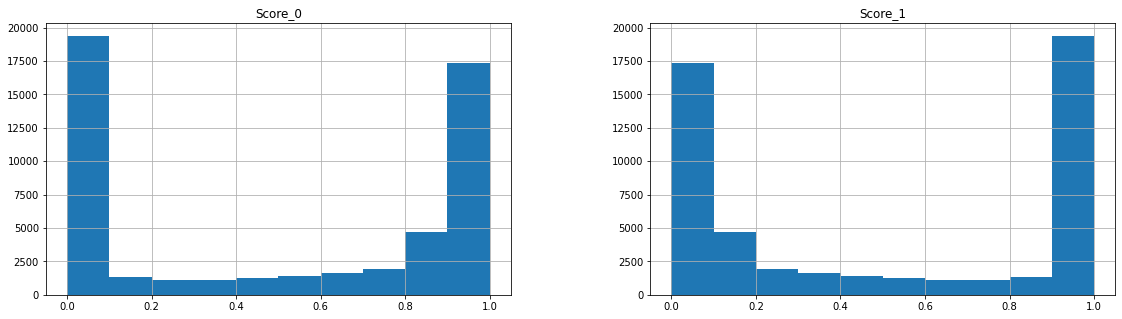

In [35]:
df_inference.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

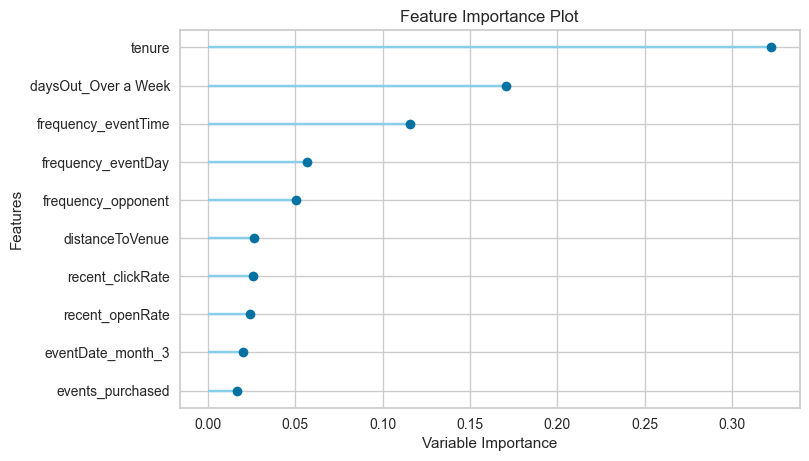

In [36]:
plot_model(best_model, plot='feature')

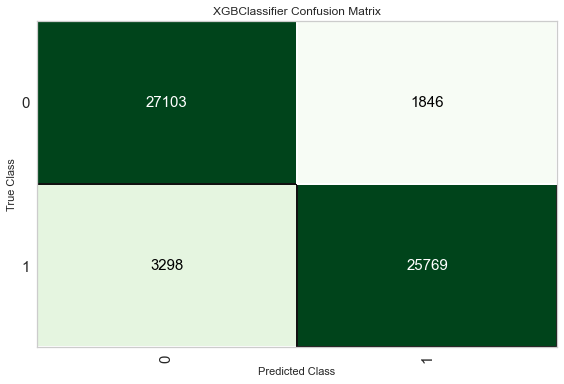

In [37]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.